# Building an unstructured mesh

<div class="alert alert-block alert-info"> In this example, we use the ESRI Grid for Australia available from Geoscience Australia product catalogue (https://ecat.ga.gov.au/geonetwork/). You could download it when searching for Australian Bathymetry and Topography Grid, June 2009.  

We also provide in data folder a low resolution GeoTIFF that can also be used for this tutorial (AUS_LR.tiff). 


We will first _reproject the dataset_ in UTM coordinates, then we will use _shapefiles and countours_ to clipped on region of interested and then we will use </div>


We will create the following mesh:

***

<img src="images/australia.png" width="80%">

***



## Notebook contents

   - [Converting from lon/lat to metres](#Converting-from-lon/lat-to-metres)
   - [Clipped elevation grid](#Clipped-elevation-grid)
   - [X & Y axes](#X-&-Y-axes)
   - [Define contour lines](#Define-contour-lines)
   - [Unstructured elevation grid](#Unstructured-elevation-grid)
   - [Visualisation](#Visualisation)


In [1]:
import pycpt
import lavavu

import meshio
import numpy as np
import pygmsh as pg
import fillit as pitfill

from scipy.interpolate import RectBivariateSpline

from collections import OrderedDict

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.path import Path
from mpl_toolkits.axes_grid1 import make_axes_locatable

import meshplex
from eSCAPE._fortran import defineGTIN

label_size = 8
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size

%matplotlib inline
%config InlineBackend.figure_format = 'svg' 

# Converting from lon/lat to metres

To reproject the grid from lon/lat coordinates to UTM (metres), two main libraries are available within the Docker image:

+ `pygeotools` -- https://github.com/dshean/pygeotools
+ `rasterio` -- https://github.com/mapbox/rasterio

First, we specify our DEM filename:

In [2]:
filename = 'data/AUS_LR.tiff'

Below, we show how this can be done using rasterio. First we load the required libraries and then define the requested projection (here we used EPSG reference for the region EPSG:28355).

In [3]:
import rasterio
from rasterio import crs
from rasterio.warp import calculate_default_transform, reproject, Resampling

# Reproject to EPSG zone
dst_crs = {'init': 'EPSG:28355'}

# Requested reprojected dataset resolution (metres)
utmRes = 10000.

We then use the following cell to make the projection and get the interpolated elevation points at the requested resolution (elev -- a numpy masked array)

In [4]:
with rasterio.drivers(CHECK_WITH_INVERT_PROJ=True):
    with rasterio.open(filename) as src:
        
        profile = src.profile
        if src.nodata is None:
            nodata = -32768.0
        else:
            nodata = src.nodata
        
        # Calculate the ideal dimensions and transformation in the new crs
        dst_affine, dst_width, dst_height = calculate_default_transform(
            src.crs, dst_crs, src.width, src.height, *src.bounds, resolution=utmRes)

        # update the relevant parts of the profile
        profile.update({
            'crs': dst_crs,
            'transform': dst_affine,
            'affine': dst_affine,
            'width': dst_width,
            'height': dst_height
        })

        # Reproject and write each band
        src_array = src.read()
        dst_array = np.empty((int(dst_height), int(dst_width)), dtype='int16')

        reproject(
                # Source parameters
                source=src_array,
                src_crs=src.crs,
                src_transform=src.affine,
                src_nodata=nodata,

                # Destination paramaters
                destination=dst_array,
                dst_transform=dst_affine,
                dst_crs=dst_crs,
                dst_nodata=nodata,

                # Configuration
                resampling=Resampling.nearest,
                num_threads=2)

        elev = np.ma.masked_where(dst_array == nodata, dst_array)

We can look at the metadata associated with the new GeoTIFF file using for example:

In [5]:
profile

{'affine': Affine(10000.0, 0.0, -3881351.8520504497,
        0.0, -10000.0, 9115700.95122636),
 'compress': 'deflate',
 'count': 1,
 'crs': {'init': 'EPSG:28355'},
 'driver': u'GTiff',
 'dtype': 'int16',
 'height': 482.0,
 'interleave': 'band',
 'nodata': -32768.0,
 'tiled': False,
 'transform': Affine(10000.0, 0.0, -3881351.8520504497,
        0.0, -10000.0, 9115700.95122636),
 'width': 527.0}

# Clipped elevation grid

We can visualise the new elevation array using the following function:

In [6]:
def plotElevation( data, cmin, cmax, colormap):
    '''
    data: dataset to plot
    zmin,zmax: extent of the colormap
    colormap: to use    
    '''
    
    # Figure size is defined here
    fig = plt.figure(1, figsize=(8,8))
    
    ax = plt.gca()
    im = ax.imshow(data, interpolation='nearest', cmap=colormap,
                     vmin=cmin, vmax=cmax)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="3%", pad=0.1)
    cbar = plt.colorbar(im,cax=cax)
    plt.tight_layout()

    plt.show()
    plt.close(fig)

We choose to use pycpt -- Python tools to load and handle cpt (GMT format) color maps for use with matplotlib (e.g. from cpt-city)
You can pick a colorbar from the following website:
    
- http://soliton.vm.bytemark.co.uk/pub/cpt-city/index.html

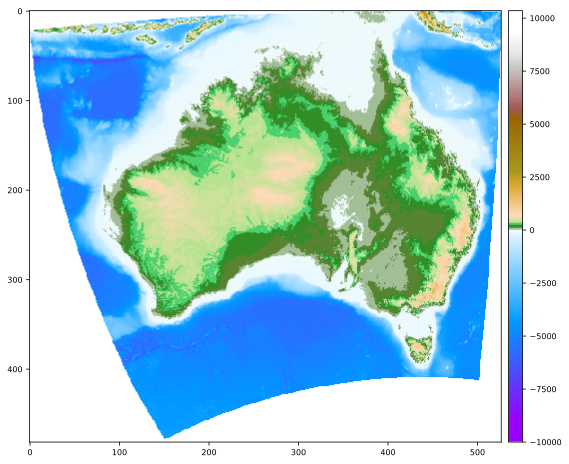

In [7]:
topocmap = pycpt.load.cmap_from_cptcity_url('gmt/GMT_globe.cpt')
plotElevation( elev, -10000, 10350, topocmap)

As you can see from the figure above, we will need to clip our array to remove the nodata values induced by the reprojection... We do that by just selecting the extent of the rows and columns number from our elev numpy array...

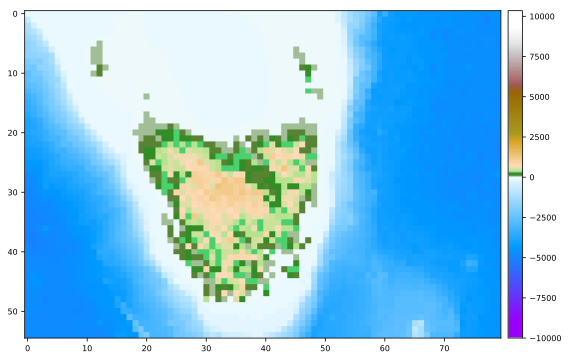

In [8]:
plotElevation( elev[345:400,400:480], -10000, 10350, topocmap)

We then defined a new elevation array dem based on the clipped one:

In [9]:
dem = elev[345:400,400:480]

# X & Y axes

To keep your coordinates system for post-processing and to potentially reproject the outputs from the landscape evolution model in another geospatial system we needs to specify the X and Y axes.
We do it like this

In [10]:
xMin = dst_affine[2]
xMax = dst_affine[2] + abs(dst_affine[0])*dst_width

yMin = dst_affine[5] - abs(dst_affine[4])*dst_height
yMax = dst_affine[5]

print("Initial DEM:\n")

print("Lower left coordinates       Xmin: {}, Ymin: {}".format(xMin,yMin))
print("Upper right coordinates      Xmax:  {}, Ymax: {}".format(xMax,yMax))

Initial DEM:

Lower left coordinates       Xmin: -3881351.85205, Ymin: 4295700.95123
Upper right coordinates      Xmax:  1388648.14795, Ymax: 9115700.95123


We can now create the X and Y coordinates, at this point we can choose to decrease the resolution if needed by using the step parameter (integer)

In [11]:
step = 1
spacing = utmRes*step

Z = dem[::step,::step]

nx = Z.shape[1]
ny = Z.shape[0]

minX, maxX = xMin, xMin+spacing*nx
minY, maxY = yMin, yMin+spacing*ny

xcoords = np.arange(minX, maxX, spacing)
ycoords = np.arange(minY, maxY, spacing)

X, Y = np.meshgrid(xcoords, ycoords)

coords = np.vstack([X.ravel(), Y.ravel()])

print("Clipped DEM:\n")

print("Resolution (m)            res: {}".format(spacing))
print("Number of points         nbpt: {}".format(coords.shape[0]))
print("Elevation map shape        nx: {}, ny: {}\n".format(nx,ny))

print("Lower left coordinates   Xmin: {}, Ymin: {}".format(minX,minY))
print("Upper right coordinates  Xmax: {}, Ymax: {}".format(maxX,maxY))

Clipped DEM:

Resolution (m)            res: 10000.0
Number of points         nbpt: 2
Elevation map shape        nx: 80, ny: 55

Lower left coordinates   Xmin: -3881351.85205, Ymin: 4295700.95123
Upper right coordinates  Xmax: -3081351.85205, Ymax: 4845700.95123


# Define contour lines

From the projected digital elevation, we will extract contour lines at given depth and use these lines to define the extent of our simulation region and its resolution. 

First we define the `extractContours` function that returns the list of countour lines

In [12]:
def extractContours( X, Y, Z, cmin, cmax, colormap, ctrlist):
    '''
    coords: coordinate points (X,Y,X)
    cmin,cmax: extent of the colormap
    colormap: color scale to use
    ctrlist: list of contours to extract
    '''
    # Figure size is defined here
    fig = plt.figure(1, figsize=(8,8))
    ctrs = []
    for k in range(len(ctrlist)):
        ctrs.append(plt.contour(X, Y, 
                    np.flipud(Z), ctrlist[k]))
    ax = plt.gca()
    im = ax.imshow(Z, interpolation='nearest', cmap=colormap,
                     vmin=cmin, vmax=cmax,extent=[minX, maxX,minY, maxY])
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="3%", pad=0.1)
    cbar = plt.colorbar(im,cax=cax)
    plt.tight_layout()

    plt.show()
    plt.close(fig)

    return ctrs

Then we specify a list of contour line depths `ctrList` that needs to be defined in **ascending order** (this is important for what follows)

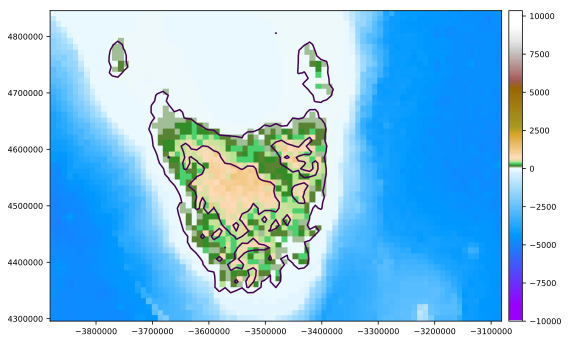

In [13]:
ctrList = [-10.,500.]

# Now we extract the contours lines using the previous function
if sorted(ctrList) == ctrList:
    ctrs = extractContours(X, Y, Z, -10000, 10350, topocmap, ctrList)
else:
    print("ERROR:")
    print("The list of contour positions needs to be specify in ascending order!")
    print("Redefine the ctrList variable")

We can see from the figure above that we have several contour lines for any single depth. We will only use the **longest lines for each depth** to define our simulation domain.

To do so we will define two functions:
+ `distancePts`: that will be used to get the euclidian distance between 2 points
+ `getLongestContoursXY`: that extract the longest lines and resample it based on a characteristic length `lcar`

In [14]:
def distancePts(p1,p2):
    '''
    Compute the euclidian distance between 2 points (p1, p2)
    
    '''
    return (p1[1]-p2[1])**2+(p1[0]-p2[0])**2 

In [15]:
def getLongestContoursXY(ctrs, lcar):
    '''
    1- Extract from the list of contour points the longest path
    2- Using a characteristic length (lcar) resample the path 
    3- Return the XY coordinates of the longest paths
    '''

    ctrPoints = []
    # Loop through the contour lines 
    for ct in range(len(ctrs)):
        cpath = []
        k = 0
        maxpts = 0
        pathID = 0
        
        # For each contour extract the longest path
        for collection in ctrs[ct].collections:
            for path in collection.get_paths():
                if len(path)>4:
                    cpath.append(np.asarray(path.to_polygons()[0]))
                    # Storing longest path
                    if cpath[-1].shape[0] > maxpts:
                        maxpts =  cpath[-1].shape[0]
                        pathID = k
                    k += 1

        # Find longest path XY coordinates 
        Cpts = cpath[pathID]
        x = Cpts[:,0]
        y = Cpts[:,1]
        tmp = OrderedDict()
        for pt in zip(x,y):
            tmp.setdefault(pt[:1], pt)   
        ctrPts = np.asarray(tmp.values())  

        # Resample the path to the requested characteristic length
        ki = 0
        tmpPts = []
        cumdist = 0.
        tmpPts.append(ctrPts[0,:])
        for k in range(1,ctrPts.shape[0]):
            cumdist = distancePts(ctrPts[ki,:2], ctrPts[k,:2])
            if(cumdist >= lcar):
                tmpPts.append(ctrPts[k,:])
                ki = k
        ctrPoints.append(np.asarray(tmpPts))

    return ctrPoints

The `getLongestContoursXY` function will return the longest line resampled points coordinates for each contour depths defined in `ctrList`

In [16]:
ctrPoints = getLongestContoursXY(ctrs, 300000.)

Let's plot the picked contour lines...

In [17]:
def plotContours( X, Y, Z, cmin, cmax, colormap, ctrPts):
    '''
    coords: coordinate points (X,Y)
    zmin,zmax: extent of the colormap
    colormap: to use  
    ctrPts: coordinates of contour lines
    '''
    # Figure size is defined here
    fig = plt.figure(1, figsize=(8,8))
    ctrs = []
    for k in range(len(ctrPts)):
        plt.scatter(ctrPts[k][:,0], ctrPts[k][:,1], s=0.3, c='k')
    ax = plt.gca()
    im = ax.imshow(Z, interpolation='nearest', cmap=colormap,
                     vmin=cmin, vmax=cmax,extent=[minX, maxX,minY, maxY])
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="3%", pad=0.1)
    cbar = plt.colorbar(im,cax=cax)
    plt.tight_layout()

    plt.show()
    plt.close(fig)

    return 

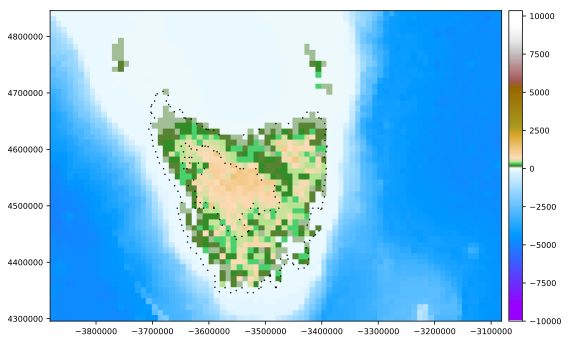

In [18]:
plotContours(X, Y, Z, -10000, 10350, topocmap, ctrPoints)

# Unstructured elevation grid

We use `pyGmsh` library, an interface to `Gmsh` to build our unstructured grid:

+ https://github.com/nschloe/pygmsh

We first initialise a `pyGmsh` instance and define some options:
+ `gmsh_out`: verbose from Gmsh mesh creation
+ `gmsh_args`: Gmsh command line options: http://gmsh.info/doc/texinfo/gmsh.html#Command_002dline-options

In [19]:
geom = pg.built_in.Geometry()

# Gmsh options
gmsh_out = True
gmsh_args = ['-clmin', '20000', '-smooth', '10']

### Gmsh geometries and surface creation

The resolution of the mesh is defined based on the characteristic length parameter `lcar` defined at specific points in the geometry. Here we use a coarse resolution (`lcar1`) for the boundary line (the contour at depth _-1000m_) and a higher resolution (`lcar2`) for the contour at _500m_. 

Each of these contours are exported as a `Gmsh` polyline geometry using the `GmeshPolyline` function below:

In [20]:
def GmeshPolyline(GmshGeo, ctrPts, lcar):
    '''
    Define a polyline for Gmsh geometry (GmshGeo) based on a list of coonected 
    points (contour line ctrPts) and a characteristic length (lcar)
    '''
    Points_done=dict()
    Line_loops=dict()
    Line_done=dict()

    # 1- Contour coordinates definition
    for i in range(ctrPts.shape[0]):
        Points_done[i]=GmshGeo.add_point([ctrPts[i][0], ctrPts[i][1], 0.], lcar)

    # 2- Lines between points definition
    lineLoop=[]
    for i in range(ctrPts.shape[0]):
        if i < ctrPts.shape[0]-1:
            Line_done[i]=GmshGeo.add_line(Points_done[i],Points_done[i+1])
        else:
            Line_done[i]=GmshGeo.add_line(Points_done[i],Points_done[0])
        lineLoop.append(Line_done[i])

    return GmshGeo.add_line_loop(lineLoop)

In [21]:
# External contour Gmsh characteristic length
lcar1 = 30000.

# Create polyline for contour line at -1000 m depth
polyline1 = GmeshPolyline(geom, ctrPoints[0], lcar1)

# Refined region Gmsh characteristic length
lcar2 = 5000.

# Create polyline for contour line at 500 m 
polyline2 = GmeshPolyline(geom, ctrPoints[1], lcar2)

`Gmsh` allows to combine different shapes together using _surface_ geometry and combining/removing parts of it as required. In this example, we will first create a surface at coarse resolution between the deepest contour and the second one (this is done by defining holes in the surface). 

Then we add to this surface a second higher resolution one that fills the central hole.  

For an extensive overview of the capability of `Gmsh`, users can refer to the following documentation:
+ http://gmsh.info/doc/texinfo/gmsh.html

It is worth noting that not all the functionalities of `Gmsh` are available in the provided Docker container.

In [22]:
# Adding coarse surface on the external domain of the mesh using the holes expression
geom.add_plane_surface(polyline1,holes=[polyline2]) 

# Adding refined surface in the region within the second polyline
geom.add_plane_surface(polyline2) 

# Generate Gmsh triangulation
mesh = pg.generate_mesh(geom, dim = 2, 
                                       verbose = gmsh_out,
                                       #geo_filename='ausGmsh.geo',
                                       extra_gmsh_arguments=gmsh_args)

pts = mesh.points
cells = mesh.cells

Info    : Running 'gmsh -2 /tmp/tmpe9k1_c.geo -format msh -bin -o /tmp/tmpttDYP7.msh -clmin 20000 -smooth 10' [Gmsh 4.3.0-git-fdbcd7f, 1 node, max. 1 thread]
Info    : Started on Thu Feb 20 05:01:01 2020
Info    : Reading '/tmp/tmpe9k1_c.geo'...
Info    : Done reading '/tmp/tmpe9k1_c.geo'
Info    : Meshing 1D...
Info    : Meshing curve 1 (Line)
Info    : Meshing curve 2 (Line)
Info    : Meshing curve 3 (Line)
Info    : Meshing curve 4 (Line)
Info    : Meshing curve 5 (Line)
Info    : Meshing curve 6 (Line)
Info    : Meshing curve 7 (Line)
Info    : Meshing curve 8 (Line)
Info    : Meshing curve 9 (Line)
Info    : Meshing curve 10 (Line)
Info    : Meshing curve 11 (Line)
Info    : Meshing curve 12 (Line)
Info    : Meshing curve 13 (Line)
Info    : Meshing curve 14 (Line)
Info    : Meshing curve 15 (Line)
Info    : Meshing curve 16 (Line)
Info    : Meshing curve 17 (Line)
Info    : Meshing curve 18 (Line)
Info    : Meshing curve 19 (Line)
Info    : Meshing curve 20 (Line)
Info    : Meshi

In [23]:
print("Unstructured Grid:\n")

print("Number of points         nbpt: {}".format(pts.shape[0]))
print("Number of faces       nbcells: {}".format(cells['triangle'].shape[0]))

Unstructured Grid:

Number of points         nbpt: 1234
Number of faces       nbcells: 2338


The last step consists in defining a _bivariate spline approximation_ over the rectangular mesh (`scipy.interpolate.RectBivariateSpline`) that will be used to get the elevation on the unstructured grid vertices.

In [24]:
interpolateFct = RectBivariateSpline(xcoords,ycoords,np.flipud(Z).T)

We then perform the elevation interpolation on the triangulation coordinates:

In [25]:
# Interpolation of the elevation on the triangulation
evalZ = interpolateFct.ev(pts[:,0], pts[:,1])
evalZ[evalZ < min(ctrList)] = min(ctrList) 

# Creation of the X,Y,Z coordinates of the unstructured grid
verts = np.insert(pts[:,:2], 2, values=evalZ, axis=1)

## Pit filling

In [26]:
Gmesh = meshplex.mesh_tri.MeshTri(pts, cells['triangle'])

ids = np.arange(0, len(Gmesh.node_coords), dtype=int)
Gmesh.mark_boundary()
bndID = np.where(Gmesh._is_boundary_node == True)[0]

Gmesh.create_edges()
garea = np.abs(Gmesh.control_volumes)

Gmesh_ngbNbs, Gmesh_ngbID = defineGTIN(len(Gmesh.node_coords), Gmesh.cells['nodes'], Gmesh.edges['nodes'])

In [27]:
eps = 1.e-4
seaID = np.where(evalZ<-50)[0]

meshID = np.ones(len(Gmesh.node_coords))
eScapeGPit = pitfill.depressionFillingScape(coords=Gmesh.node_coords, ngbIDs=Gmesh_ngbID, 
                                            ngbNb=Gmesh_ngbNbs, seaIDs=seaID, meshIDs=meshID,
                                            boundary=bndID, first=1, area=garea)

In [28]:
fill = eScapeGPit.performPitFillingEpsilon(evalZ, bndID, eps, type=0)
fill[seaID] = evalZ[seaID]

# Creation of the X,Y,Z coordinates of the unstructured grid
vertsR = np.insert(pts[:,:2], 2, values=fill, axis=1)

# Visualisation

Finally we use `lavavu` to visualise the new unstructured grid. It is done by using the following things:

+ points coordinates (`verts`) 
+ the IDs of the connected points forming each triangle faces (`cells['triangle']`).

In [29]:
lv = lavavu.Viewer(border=True, background="#FFFFFF", resolution=[700,700], near=-10.0)

# Core 
lvTriG = lv.triangles("DelGmsh",  wireframe=False, colour="#161616", opacity=1.0)
lvTriG.vertices(verts)
lvTriG.indices(cells['triangle'])
lvTriG.values(fill)
lvTriG.colourmap("geo", range=[-2000.,2000.])
#cbar2.colourmap(name, discrete=True, range=[-6,6])
lv.translation(823.959, 14666.457, -6244788.5)
lv.rotation(-21.213, 3.086, -0.158)
lv.scale('z', 75)

lv.control.Checkbox(property='axis')
lvTriG.control.Checkbox(property='wireframe', label="wireframe")
lv.control.Panel()
lv.control.ObjectList()
lvTriG.control.Range(command='scale z', range=(1,201), step=10., value=100)
lv.control.show()

<IPython.core.display.Javascript object>

We can now save the unstructured mesh as a **VTU** file (VTK format) using `meshio` library

In [30]:
mesh = meshio.Mesh(pts, cells, {'Z':fill})
meshio.write("data/TAS.vtk", mesh)